In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from mnist import Mnist

Activations 

In [2]:


class Activations:
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    # for multi-dimensional x
    def softmax(self, x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T 

        x = x - np.max(x)  
        return np.exp(x) / np.sum(np.exp(x))

Errors

In [3]:
class Errors:
    def cross_entropy_error(self, y, t):
        delta = 1e-7
        batch_size = 1 if y.ndim == 1 else y.shape[0]

        return -np.sum(t*np.log(y + delta)) / batch_size

Relu, Sigmoid, Affine and SoftmaxWithLoss Class

In [4]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None
        self.activations = Activations()

    def forward(self, x):
        out = self.activations.sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
        self.x = None
        self.original_x_shape = None

        self.dw = None
        self.db = None

    def forward(self, x):
        # 
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.w) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.w.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None 
        self.y_hat = None    
        self.y = None    
        self.activations = Activations()
        self.errors = Errors()
        
    def forward(self, x, y):
        self.y = y
        self.y_hat = self.activations.softmax(x)
        self.loss = self.errors.cross_entropy_error(self.y_hat, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        #if self.y.size == self.y_hat.size: # one hot encoding
        
        dx = (self.y_hat - self.y) / batch_size
        
        """
        else:
            dx = self.y_hat.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        """
        return dx

TwoLayerNetWithBackProp class

In [7]:
from collections import OrderedDict

In [8]:
class TwoLayerNetWithBackProp:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}

        self.params['w1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)

        self.params['w2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.activations = Activations()
        self.errors = Errors()

        # add layers
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Rele1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])

        self.last_layer = SoftmaxWithLoss()


    def predict(self, x):
        ## new implementation for backprop
        for layer in self.layers.values():
            x = layer.forward(x)

        y = x
        return y
    
    def loss(self, x, y):
        y_hat = self.predict(x)

        # return self.errors.cross_entropy_error(y_hat, y)
        return self.last_layer.forward(y_hat, y)

    def accuracy(self, x, y):
        y_hat = self.predict(x)
        p = np.argmax(y_hat, axis=1)
        y_p = np.argmax(y, axis=1)

        return np.sum(p == y_p)/float(x.shape[0])
    

    def gradient(self, x, y):
        self.loss(x, y)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        
      
        return grads

Training the Data

In [9]:
mnist = Mnist()
(x_train, y_train), (x_test, y_test) = mnist.load()


File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.


In [10]:

network = TwoLayerNetWithBackProp(input_size=28*28, hidden_size=500, output_size=10)

In [11]:
iterations = 10000
train_size = x_train.shape[0]
batch_size = 16
lr = 0.01

In [ ]:
iter_per_epoch = max(train_size // batch_size, 1)

In [13]:
train_losses = []
train_accs = []
test_accs = []

In [14]:
for i in range(iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]

    grads = network.gradient(x_batch, y_batch)

    # Update parameters and store in uppercase keys to match mnist.py expectations
    for key in ('w1', 'b1', 'w2', 'b2' ):
        network.params[key] -= lr * grads[key.lower()]

    # Record training loss
    train_losses.append(network.loss(x_batch, y_batch))

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f'Epoch {i // iter_per_epoch}: train acc = {train_acc}, test acc = {test_acc}')

Epoch 0: train acc = 0.09828333333333333, test acc = 0.0971
Epoch 1: train acc = 0.8997, test acc = 0.9025
Epoch 2: train acc = 0.9177, test acc = 0.9196


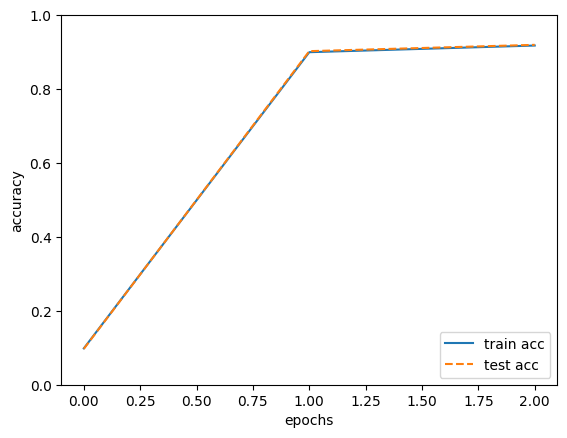

In [15]:
""" 
Plot accuracy over epochs
"""

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_accs))
plt.plot(x, train_accs, label='train acc')
plt.plot(x, test_accs, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [16]:
"""
Save the trained parameters to pickle file with uppercase keys
"""
my_weight_pkl_file = 'bhatia_mnist_model.pkl'
with open(my_weight_pkl_file, 'wb') as f:
    print(f'Pickle: {my_weight_pkl_file} is being created.')
    pickle.dump(network.params, f)
    print('Done.')

Pickle: bhatia_mnist_model.pkl is being created.
Done.


Testing the trained Dataset

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.


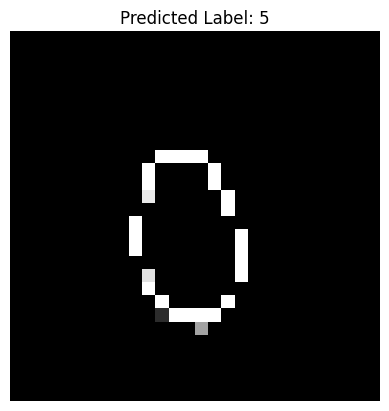

Fail: Image ./Custom MNIST Samples/Digit 0/0_0.png is for digit 0 but the inference result is 5.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mnist import Mnist 
from mnist_data import MnistData 

# Assuming Mnist and MnistData classes are defined and initialized
mnist = Mnist()
mnist.init_network()  # Make sure the network is initialized with weights

def load_and_predict_image(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image loaded successfully
    if img is None:
        print(f"Error: Could not load image from path {image_path}")
        return None

    # Resize the image to 28x28 if it isn't already
    if img.shape != (28, 28):
        img = cv2.resize(img, (28, 28))
    
    # Normalize and flatten the image
    img = img.astype(np.float32)
    img /= 255.0
    img = img.reshape(-1)  # Flatten to match the input shape

    # Predict using the initialized Mnist network
    prediction = mnist.predict(img)
    predicted_label = np.argmax(prediction)

    # Display the image using matplotlib for Jupyter compatibility
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()  # Display inline in Jupyter

    return predicted_label

def predict_and_display(image_filename, expected_digit):
    # Predict the label for the input image
    predicted_label = load_and_predict_image(image_filename)
    
    if predicted_label is None:
        print("Prediction failed due to an image loading error.")
        return

    # Check if the prediction matches the expected digit
    if predicted_label == expected_digit:
        print(f"Success: Image {image_filename} is for digit {expected_digit} and is recognized as {predicted_label}.")
    else:
        print(f"Fail: Image {image_filename} is for digit {expected_digit} but the inference result is {predicted_label}.")

# Set the image path and expected digit here
image_filename = "./Custom MNIST Samples/Digit 0/0_0.png"  
expected_digit = 0  

# Run the prediction
predict_and_display(image_filename, expected_digit)

Testing using module6.py

In [2]:
!python module6.py "./Custom MNIST Samples/Digit 0/0_0.png" 0

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 0/0_0.png is for digit 0 but the inference result is 5.


In [4]:
!python module6.py "./Custom MNIST Samples/Digit 0/0_1.png" 0

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 0/0_1.png is for digit 0 but the inference result is 2.


In [5]:
!python module6.py "./Custom MNIST Samples/Digit 0/0_3.png" 0

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 0/0_3.png is for digit 0 but the inference result is 5.


In [6]:
!python module6.py "./Custom MNIST Samples/Digit 0/0_4.png" 0

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 0/0_4.png is for digit 0 but the inference result is 2.


Testing using predict_and_display function 

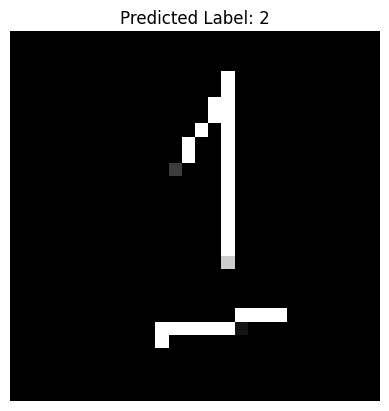

Fail: Image ./Custom MNIST Samples/Digit 1/1_0.png is for digit 1 but the inference result is 2.


In [7]:
image_filename = "./Custom MNIST Samples/Digit 1/1_0.png"  
expected_digit = 1  

# Run the prediction
predict_and_display(image_filename, expected_digit)

When i call module6.py into jupyter notebook it does not show the image for some reason

In [8]:
!python module6.py "./Custom MNIST Samples/Digit 1/1_1.png" 1

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 1/1_1.png is for digit 1 but the inference result is 5.


In [9]:
!python module6.py "./Custom MNIST Samples/Digit 1/1_2.png" 1

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 1/1_2.png is for digit 1 but the inference result is 2.


In [10]:
!python module6.py "./Custom MNIST Samples/Digit 1/1_3.png" 1

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 1/1_3.png is for digit 1 but the inference result is 5.


In [11]:
!python module6.py "./Custom MNIST Samples/Digit 1/1_4.png" 1

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 1/1_4.png is for digit 1 but the inference result is 2.


In [12]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_0.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_0.png is for digit 2 and is recognized as 2.


In [13]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_1.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_1.png is for digit 2 and is recognized as 2.


In [14]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_2.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_2.png is for digit 2 and is recognized as 2.


In [15]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_3.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_3.png is for digit 2 and is recognized as 2.


In [16]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_3.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_3.png is for digit 2 and is recognized as 2.


In [17]:
!python module6.py "./Custom MNIST Samples/Digit 2/2_4.png" 2

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 2/2_4.png is for digit 2 and is recognized as 2.


In [18]:
!python module6.py "./Custom MNIST Samples/Digit 3/3_0.png" 3

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 3/3_0.png is for digit 3 but the inference result is 2.


In [19]:
!python module6.py "./Custom MNIST Samples/Digit 3/3_1.png" 3

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 3/3_1.png is for digit 3 but the inference result is 2.


In [20]:
!python module6.py "./Custom MNIST Samples/Digit 3/3_2.png" 3

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 3/3_2.png is for digit 3 but the inference result is 2.


In [21]:
!python module6.py "./Custom MNIST Samples/Digit 3/3_3.png" 3

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 3/3_3.png is for digit 3 but the inference result is 2.


In [22]:
!python module6.py "./Custom MNIST Samples/Digit 3/3_4.png" 3

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 3/3_4.png is for digit 3 but the inference result is 2.


In [23]:
!python module6.py "./Custom MNIST Samples/Digit 4/4_0.png" 4

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 4/4_0.png is for digit 4 but the inference result is 5.


In [24]:
!python module6.py "./Custom MNIST Samples/Digit 4/4_1.png" 4

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 4/4_1.png is for digit 4 but the inference result is 5.


In [25]:
!python module6.py "./Custom MNIST Samples/Digit 4/4_2.png" 4

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 4/4_2.png is for digit 4 but the inference result is 5.


In [26]:
!python module6.py "./Custom MNIST Samples/Digit 4/4_3.png" 4

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 4/4_3.png is for digit 4 but the inference result is 5.


In [27]:
!python module6.py "./Custom MNIST Samples/Digit 4/4_4.png" 4

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 4/4_4.png is for digit 4 but the inference result is 5.


In [28]:
!python module6.py "./Custom MNIST Samples/Digit 5/5_0.png" 5

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 5/5_0.png is for digit 5 and is recognized as 5.


In [29]:
!python module6.py "./Custom MNIST Samples/Digit 5/5_1.png" 5

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 5/5_1.png is for digit 5 and is recognized as 5.


In [30]:
!python module6.py "./Custom MNIST Samples/Digit 5/5_2.png" 5

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 5/5_2.png is for digit 5 and is recognized as 5.


In [31]:
!python module6.py "./Custom MNIST Samples/Digit 5/5_3.png" 5

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 5/5_3.png is for digit 5 and is recognized as 5.


In [32]:
!python module6.py "./Custom MNIST Samples/Digit 5/5_4.png" 5

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Success: Image ./Custom MNIST Samples/Digit 5/5_4.png is for digit 5 and is recognized as 5.


In [33]:
!python module6.py "./Custom MNIST Samples/Digit 6/6_0.png" 6

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 6/6_0.png is for digit 6 but the inference result is 5.


In [34]:
!python module6.py "./Custom MNIST Samples/Digit 6/6_1.png" 6

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 6/6_1.png is for digit 6 but the inference result is 5.


In [35]:
!python module6.py "./Custom MNIST Samples/Digit 6/6_2.png" 6

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 6/6_2.png is for digit 6 but the inference result is 5.


In [36]:
!python module6.py "./Custom MNIST Samples/Digit 6/6_3.png" 6

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 6/6_3.png is for digit 6 but the inference result is 5.


In [37]:
!python module6.py "./Custom MNIST Samples/Digit 6/6_4.png" 6

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 6/6_4.png is for digit 6 but the inference result is 5.


In [38]:
!python module6.py "./Custom MNIST Samples/Digit 7/7_0.png" 7

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 7/7_0.png is for digit 7 but the inference result is 5.


In [39]:
!python module6.py "./Custom MNIST Samples/Digit 7/7_1.png" 7

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 7/7_1.png is for digit 7 but the inference result is 5.


In [40]:
!python module6.py "./Custom MNIST Samples/Digit 7/7_2.png" 7

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 7/7_2.png is for digit 7 but the inference result is 5.


In [41]:
!python module6.py "./Custom MNIST Samples/Digit 7/7_3.png" 7

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 7/7_3.png is for digit 7 but the inference result is 2.


In [42]:
!python module6.py "./Custom MNIST Samples/Digit 7/7_4.png" 7

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 7/7_4.png is for digit 7 but the inference result is 2.


In [43]:
!python module6.py "./Custom MNIST Samples/Digit 8/8_0.png" 8

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 8/8_0.png is for digit 8 but the inference result is 5.


In [44]:
!python module6.py "./Custom MNIST Samples/Digit 8/8_1.png" 8

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 8/8_1.png is for digit 8 but the inference result is 5.


In [45]:
!python module6.py "./Custom MNIST Samples/Digit 8/8_2.png" 8

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 8/8_2.png is for digit 8 but the inference result is 5.


In [46]:
!python module6.py "./Custom MNIST Samples/Digit 8/8_3.png" 8

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 8/8_3.png is for digit 8 but the inference result is 5.


In [47]:
!python module6.py "./Custom MNIST Samples/Digit 8/8_4.png" 8

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 8/8_4.png is for digit 8 but the inference result is 5.


In [48]:
!python module6.py "./Custom MNIST Samples/Digit 9/9_0.png" 9

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 9/9_0.png is for digit 9 but the inference result is 5.


In [49]:
!python module6.py "./Custom MNIST Samples/Digit 9/9_1.png" 9

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 9/9_1.png is for digit 9 but the inference result is 5.


In [50]:
!python module6.py "./Custom MNIST Samples/Digit 9/9_2.png" 9

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 9/9_2.png is for digit 9 but the inference result is 5.


In [51]:
!python module6.py "./Custom MNIST Samples/Digit 9/9_3.png" 9

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 9/9_3.png is for digit 9 but the inference result is 5.


In [52]:
!python module6.py "./Custom MNIST Samples/Digit 9/9_4.png" 9

File: train-images-idx3-ubyte.gz already exists.
File: train-labels-idx1-ubyte.gz already exists.
File: t10k-images-idx3-ubyte.gz already exists.
File: t10k-labels-idx1-ubyte.gz already exists.
Pickle: dataset/mnist.pkl already exists.
Loading...
Done.
Figure(640x480)
Fail: Image ./Custom MNIST Samples/Digit 9/9_4.png is for digit 9 but the inference result is 5.
